In [1]:
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.layers import ECHConv2D

np.set_printoptions(precision=2, linewidth=150)


In [2]:
def get_atoms(
    kernel_profiles,
    normalize=True,
    n_harmonics=4,
):
    kernel_size, _, n_profiles = kernel_profiles.shape
    radius = (kernel_size - 1) // 2
    x_grid = np.arange(-radius, radius + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    theta = np.arctan2(y, x)
    atoms = np.zeros(
        (
            kernel_size,
            kernel_size,
            n_harmonics,
            n_profiles,
        ),
        dtype=np.csingle,
    )
    for k, i in product(range(n_harmonics), range(n_profiles)):
        atoms[:, :, k, i] = kernel_profiles[:, :, i] * np.exp(1j * k * theta)

    # atoms[:, :, 1:, 0] = 0

    if normalize:
        norm = np.sqrt(np.sum(np.conj(atoms) * atoms, axis=(0, 1)))
        norm[norm == 0] = 1
        atoms = atoms / norm

    return atoms


def compute_spectrum(
    f,
    kernel_profiles,
    n_harmonics=4,
):
    atoms = get_atoms(
        kernel_profiles=kernel_profiles,
        normalize=True,
        n_harmonics=n_harmonics,
    )
    spectrum = np.zeros((n_harmonics))
    atoms_proj = np.sum(atoms, axis=-1)
    for n in range(n_harmonics):
        ch_proj = np.sum(f * np.conj(atoms_proj[..., n]))
        spectrum[n] = np.sqrt(np.real(ch_proj * np.conj(ch_proj)))
    return spectrum


In [3]:
layer = ECHConv2D(1, 9, initializer=tf.keras.initializers.Constant(1.0))
kernel_profiles = layer.conv_ch._compute_kernel_profiles()

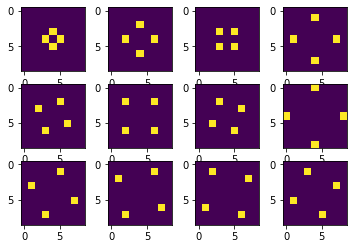

In [4]:
for k in range(12):
    plt.subplot(3,4,k+1)
    plt.imshow(kernel_profiles[:,:,k])

In [5]:
x = np.random.uniform(size=(9,9)) 
x_rotated = rotate(x, 90, reshape=False)

In [6]:

compute_spectrum(x,
                 kernel_profiles,
                 n_harmonics=8,
                 )

array([12.29,  0.73,  0.56,  1.06,  0.8 ,  0.86,  1.08,  0.35])

In [7]:
compute_spectrum(x_rotated,
                 kernel_profiles,
                 n_harmonics=8,
                 )

array([12.29,  0.73,  0.56,  1.06,  0.8 ,  0.86,  1.08,  0.35])

In [8]:
x_tot = np.stack([x, x_rotated], axis=0)[..., np.newaxis]
y = layer(x_tot)

In [9]:
y

<tf.Tensor: shape=(2, 1, 1, 4), dtype=float32, numpy=
array([[[[12.59,  0.73,  0.56,  1.06]]],


       [[[12.59,  0.73,  0.56,  1.06]]]], dtype=float32)>

In [10]:
filters  = layer.conv_ch.filters
filters = np.squeeze(filters)

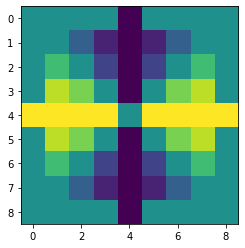

In [13]:
plt.imshow(np.real(filters[:,:, 2]))